<a href="https://colab.research.google.com/github/muhdlaziem/DR/blob/master/Random_Sampling_DenseNet(3_classes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/'My Drive'/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
nr_seed = 2019
import numpy as np 
np.random.seed(nr_seed)
import tensorflow as tf
tf.set_random_seed(nr_seed)
print(tf.__version__)

1.15.2


In [ ]:
# import libraries
import json
import math
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
import os

import cv2
from PIL import Image

import pandas as pd
import scipy
import matplotlib.pyplot as plt

from keras import backend as K
from keras import layers
from keras.applications.densenet import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

warnings.filterwarnings("ignore")

%matplotlib inline

Using TensorFlow backend.


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Image size
im_size = 320
# Batch size
BATCH_SIZE = 20

# Loading

In [ ]:
%cd diabetic-retinopathy-resized/
DR = pd.read_csv('5_3_2_levels.csv')
DR.head()

/gdrive/My Drive/diabetic-retinopathy-resized


,image,level,level(3),level(2)
0,10_left.jpeg,0,0,0
1,10_right.jpeg,0,0,0
2,13_left.jpeg,0,0,0
3,13_right.jpeg,0,0,0
4,15_left.jpeg,1,1,1


In [ ]:
DR = DR.sample(15000)

In [ ]:
DR['level(3)'].value_counts()

0    11052
1     3262
2      686
Name: level(3), dtype: int64

## Under Sampling

In [ ]:
# index_0 = DR[DR['level']==0].sample(25802-800).index
# index_1 = DR[DR['level']==1].sample(2438-753).index
# index_2 = DR[DR['level']==2].sample(5288-739).index
# index_3 = DR[DR['level']==3].sample(872-710).index
# index_4 = DR[DR['level']==4].sample(708-708).index

# undersampling_DR = DR.drop(index_0)
# undersampling_DR = undersampling_DR.drop(index_1)
# undersampling_DR = undersampling_DR.drop(index_2)
# undersampling_DR = undersampling_DR.drop(index_3)
# undersampling_DR = undersampling_DR.drop(index_4)

# undersampling_DR['level'].value_counts()

## Train - Valid split

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(DR,test_size=0.30, random_state=42)

In [ ]:
# Let's shuffle the datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
print(val_df.shape)

(10500, 4)
(4500, 4)


## Process Images

Crop function: https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping 

In [ ]:
def preprocess_image(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/40) ,-4 ,128)
    
    return img

/gdrive/My Drive/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped


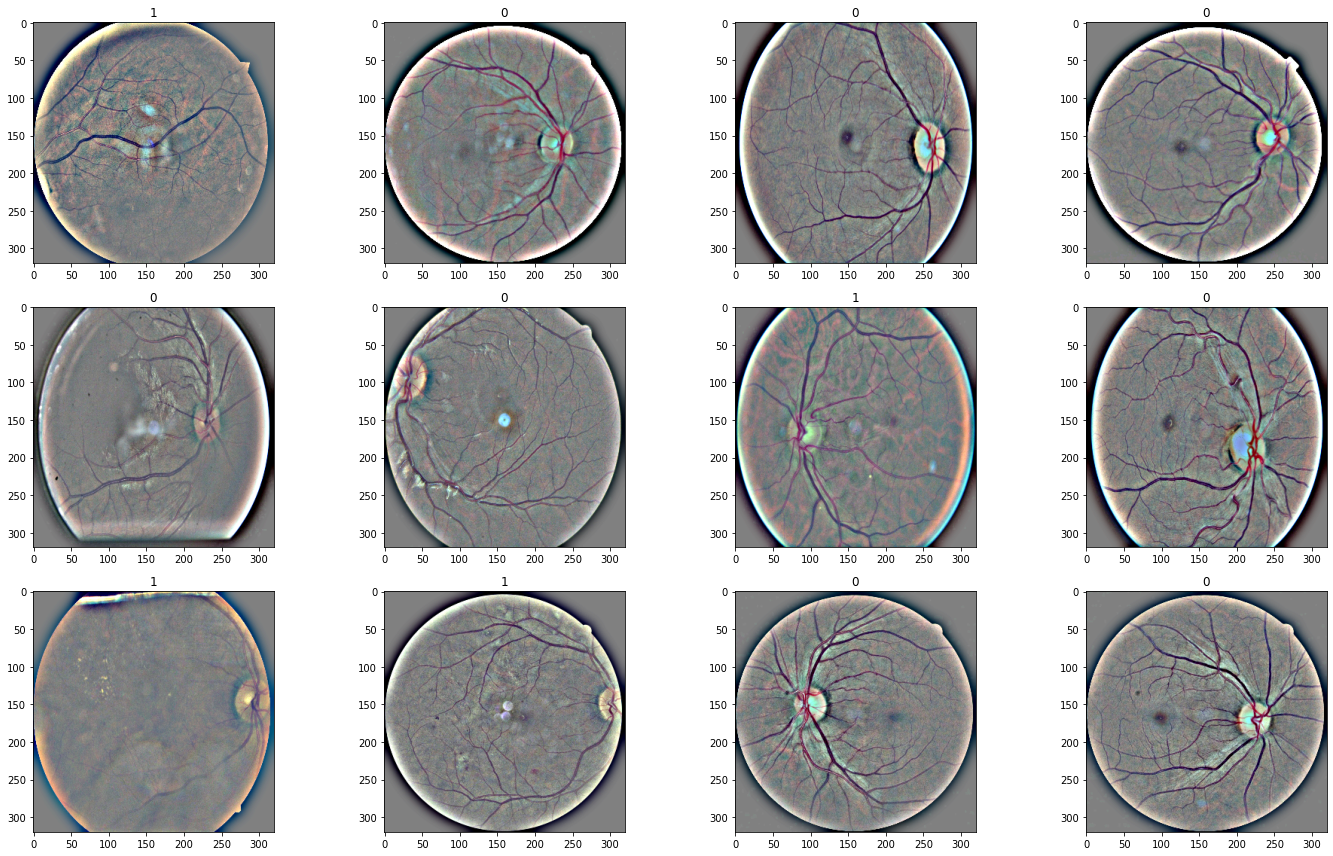

In [ ]:
%cd /gdrive/My Drive/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'image']
        image_id = df.loc[i,'level(3)']
        img = cv2.imread(f'{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = crop_image_from_gray(img)
        img = cv2.resize(img, (im_size,im_size))
        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), im_size/40) ,-4 ,128)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# Processing Images

__UPDATE:__ Here we are reading just the validation set. In order to use 320x320 images, we are going to load one bucket at a time only when needed. This will let our code run without memory-related errors.

In [ ]:
# validation set
N = val_df.shape[0]
x_val = np.empty((N, im_size, im_size, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm_notebook(val_df['image'])):
    x_val[i, :, :, :] = preprocess_image(
        f'{image_id}',
        desired_size = im_size
    )

In [ ]:
y_train = pd.get_dummies(train_df['level(3)']).values
y_val = pd.get_dummies(val_df['level(3)']).values

print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(10500, 3)
(4500, 320, 320, 3)
(4500, 3)


# Creating multilabels

Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. For more details, please check out [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets).

In [ ]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 2] = y_train[:, 2]

for i in range(1, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

y_val_multi = np.empty(y_val.shape, dtype=y_val.dtype)
y_val_multi[:, 2] = y_val[:, 2]

for i in range(1, -1, -1):
    y_val_multi[:, i] = np.logical_or(y_val[:, i], y_val_multi[:, i+1])

print("Y_train multi: {}".format(y_train_multi.shape))
print("Y_val multi: {}".format(y_val_multi.shape))

Y_train multi: (10500, 3)
Y_val multi: (4500, 3)


In [ ]:
y_train = y_train_multi
y_val = y_val_multi

# Creating keras callback for QWK

---

I had to change this function, in order to consider the best kappa score among all the buckets.

In [ ]:
class Metrics(Callback):

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('denseNet_3_all.h5')

        return

# Data Generator

In [ ]:
def create_datagen():
    return ImageDataGenerator(
        featurewise_std_normalization = True,
        horizontal_flip = True,
        vertical_flip = True,
        rotation_range = 360
    )

# Model: DenseNet-121

In [ ]:
densenet = DenseNet121(
    weights='/gdrive/My Drive/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(im_size,im_size,3)
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [ ]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.0001,decay=1e-6),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
model = build_model()
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 10, 10, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 6,956,931
Non-trainable params: 83,648
_________________________________________________________________


# Training & Evaluation

In [ ]:
#train_df = train_df.reset_index(drop=True)
bucket_num = 8
# bucket_num = 3
div = round(train_df.shape[0]/bucket_num)

In [ ]:
df_init = {
    'val_loss': [0.0],
    'val_accuracy': [0.0],
    'loss': [0.0], 
    'accuracy': [0.0],
    'bucket': [0.0]
}
results = pd.DataFrame(df_init)

In [ ]:
# I found that changing the nr. of epochs for each bucket helped in terms of performances
epochs = [5,5,10,15,15,20,20,30]
# epochs = [5,5,10]
kappa_metrics = Metrics()
kappa_metrics.val_kappas = []

In [ ]:
for i in range(0,bucket_num):
    if i != (bucket_num-1):
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:(1+i)*div].shape[0]
        x_train = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:(1+i)*div,0])):
            x_train[j, :, :, :] = preprocess_image(f'{image_id}', desired_size = im_size)

        data_generator = create_datagen().flow(x_train, y_train[i*div:(1+i)*div,:], batch_size=BATCH_SIZE)
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i
    else:
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:].shape[0]
        x_train = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:,0])):
            x_train[j, :, :, :] = preprocess_image(f'{image_id}', desired_size = im_size)
        data_generator = create_datagen().flow(x_train, y_train[i*div:,:], batch_size=BATCH_SIZE)
        
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i

    results = results.append(df_model)
    
    del data_generator
    del x_train
    gc.collect()
    
    print('-'*40)

Bucket Nr: 0




Epoch 1/5
66/65 [==============================] - 120s 2s/step - loss: 0.4715 - accuracy: 0.7929 - val_loss: 1.1260 - val_accuracy: 0.3767
val_kappa: 0.1295
Validation Kappa has improved. Saving model.
Epoch 2/5
66/65 [==============================] - 76s 1s/step - loss: 0.2556 - accuracy: 0.8968 - val_loss: 0.3400 - val_accuracy: 0.8969
val_kappa: 0.4241
Validation Kappa has improved. Saving model.
Epoch 3/5
66/65 [==============================] - 76s 1s/step - loss: 0.2329 - accuracy: 0.9014 - val_loss: 0.2408 - val_accuracy: 0.9162
val_kappa: 0.5103
Validation Kappa has improved. Saving model.
Epoch 4/5
66/65 [==============================] - 75s 1s/step - loss: 0.2094 - accuracy: 0.9151 - val_loss: 0.2427 - val_accuracy: 0.8898
val_kappa: 0.4349
Epoch 5/5
66/65 [==============================] - 75s 1s/step - loss: 0.2047 - accuracy: 0.9157 - val_loss: 0.2204 - val_accuracy: 0.9149
val_kappa: 0.3475
----------------------------------------
Bucket Nr: 1



Epoch 1/5
66/65 [==============================] - 80s 1s/step - loss: 0.2098 - accuracy: 0.9157 - val_loss: 0.2611 - val_accuracy: 0.9096
val_kappa: 0.2499
Epoch 2/5
66/65 [==============================] - 76s 1s/step - loss: 0.1994 - accuracy: 0.9200 - val_loss: 0.1821 - val_accuracy: 0.9256
val_kappa: 0.4954
Epoch 3/5
66/65 [==============================] - 77s 1s/step - loss: 0.1835 - accuracy: 0.9251 - val_loss: 0.1753 - val_accuracy: 0.9305
val_kappa: 0.5586
Validation Kappa has improved. Saving model.
Epoch 4/5
66/65 [==============================] - 76s 1s/step - loss: 0.1588 - accuracy: 0.9345 - val_loss: 0.2040 - val_accuracy: 0.9222
val_kappa: 0.4197
Epoch 5/5
66/65 [==============================] - 76s 1s/step - loss: 0.1616 - accuracy: 0.9347 - val_loss: 0.1984 - val_accuracy: 0.9168
val_kappa: 0.4656
----------------------------------------
Bucket Nr: 2



Epoch 1/10
66/65 [==============================] - 81s 1s/step - loss: 0.1914 - accuracy: 0.9258 - val_loss: 0.1802 - val_accuracy: 0.9304
val_kappa: 0.5515
Epoch 2/10
66/65 [==============================] - 76s 1s/step - loss: 0.1816 - accuracy: 0.9258 - val_loss: 0.2113 - val_accuracy: 0.9275
val_kappa: 0.4903
Epoch 3/10
66/65 [==============================] - 76s 1s/step - loss: 0.1638 - accuracy: 0.9317 - val_loss: 0.2020 - val_accuracy: 0.9278
val_kappa: 0.5029
Epoch 4/10
66/65 [==============================] - 76s 1s/step - loss: 0.1570 - accuracy: 0.9350 - val_loss: 0.2025 - val_accuracy: 0.9293
val_kappa: 0.5005
Epoch 5/10
66/65 [==============================] - 75s 1s/step - loss: 0.1561 - accuracy: 0.9388 - val_loss: 0.1796 - val_accuracy: 0.9318
val_kappa: 0.5524
Epoch 6/10
66/65 [==============================] - 75s 1s/step - loss: 0.1407 - accuracy: 0.9411 - val_loss: 0.2585 - val_accuracy: 0.9216
val_kappa: 0.4070
Epoch 7/10
66/65 [==============================] -


Epoch 1/15
66/65 [==============================] - 79s 1s/step - loss: 0.1894 - accuracy: 0.9273 - val_loss: 0.2862 - val_accuracy: 0.9104
val_kappa: 0.3047
Epoch 2/15
66/65 [==============================] - 75s 1s/step - loss: 0.1719 - accuracy: 0.9306 - val_loss: 0.2190 - val_accuracy: 0.9230
val_kappa: 0.4681
Epoch 3/15
66/65 [==============================] - 76s 1s/step - loss: 0.1629 - accuracy: 0.9329 - val_loss: 0.1732 - val_accuracy: 0.9311
val_kappa: 0.6158
Validation Kappa has improved. Saving model.
Epoch 4/15
66/65 [==============================] - 76s 1s/step - loss: 0.1533 - accuracy: 0.9411 - val_loss: 0.1853 - val_accuracy: 0.9310
val_kappa: 0.6366
Validation Kappa has improved. Saving model.
Epoch 5/15
66/65 [==============================] - 76s 1s/step - loss: 0.1542 - accuracy: 0.9403 - val_loss: 0.1805 - val_accuracy: 0.9296
val_kappa: 0.6473
Validation Kappa has improved. Saving model.
Epoch 6/15
66/65 [==============================] - 76s 1s/step - loss: 0.


Epoch 1/15
66/65 [==============================] - 80s 1s/step - loss: 0.2004 - accuracy: 0.9258 - val_loss: 0.2015 - val_accuracy: 0.9262
val_kappa: 0.5343
Epoch 2/15
66/65 [==============================] - 76s 1s/step - loss: 0.1663 - accuracy: 0.9357 - val_loss: 0.2245 - val_accuracy: 0.9320
val_kappa: 0.5312
Epoch 3/15
66/65 [==============================] - 76s 1s/step - loss: 0.1456 - accuracy: 0.9411 - val_loss: 0.3226 - val_accuracy: 0.9239
val_kappa: 0.4371
Epoch 4/15
66/65 [==============================] - 76s 1s/step - loss: 0.1550 - accuracy: 0.9390 - val_loss: 0.1958 - val_accuracy: 0.9352
val_kappa: 0.5799
Epoch 5/15
66/65 [==============================] - 76s 1s/step - loss: 0.1401 - accuracy: 0.9454 - val_loss: 0.1904 - val_accuracy: 0.9359
val_kappa: 0.5837
Epoch 6/15
66/65 [==============================] - 76s 1s/step - loss: 0.1297 - accuracy: 0.9538 - val_loss: 0.2951 - val_accuracy: 0.9253
val_kappa: 0.4803
Epoch 7/15
66/65 [==============================] -


Epoch 1/20
66/65 [==============================] - 79s 1s/step - loss: 0.2116 - accuracy: 0.9210 - val_loss: 0.1934 - val_accuracy: 0.9296
val_kappa: 0.5832
Epoch 2/20
66/65 [==============================] - 76s 1s/step - loss: 0.1589 - accuracy: 0.9339 - val_loss: 0.2075 - val_accuracy: 0.9336
val_kappa: 0.5869
Epoch 3/20
66/65 [==============================] - 75s 1s/step - loss: 0.1445 - accuracy: 0.9433 - val_loss: 0.1758 - val_accuracy: 0.9302
val_kappa: 0.5972
Epoch 4/20
66/65 [==============================] - 76s 1s/step - loss: 0.1329 - accuracy: 0.9461 - val_loss: 0.2080 - val_accuracy: 0.9293
val_kappa: 0.5383
Epoch 5/20
66/65 [==============================] - 76s 1s/step - loss: 0.1249 - accuracy: 0.9505 - val_loss: 0.2749 - val_accuracy: 0.9296
val_kappa: 0.5115
Epoch 6/20
66/65 [==============================] - 76s 1s/step - loss: 0.1180 - accuracy: 0.9563 - val_loss: 0.2180 - val_accuracy: 0.9307
val_kappa: 0.5441
Epoch 7/20
66/65 [==============================] -


Epoch 1/20
66/65 [==============================] - 81s 1s/step - loss: 0.2321 - accuracy: 0.9225 - val_loss: 0.2280 - val_accuracy: 0.9138
val_kappa: 0.5471
Epoch 2/20
66/65 [==============================] - 77s 1s/step - loss: 0.1592 - accuracy: 0.9362 - val_loss: 0.1764 - val_accuracy: 0.9262
val_kappa: 0.6256
Epoch 3/20
66/65 [==============================] - 76s 1s/step - loss: 0.1428 - accuracy: 0.9426 - val_loss: 0.2023 - val_accuracy: 0.9382
val_kappa: 0.6150
Epoch 4/20
66/65 [==============================] - 76s 1s/step - loss: 0.1312 - accuracy: 0.9464 - val_loss: 0.2053 - val_accuracy: 0.9384
val_kappa: 0.6097
Epoch 5/20
66/65 [==============================] - 76s 1s/step - loss: 0.1248 - accuracy: 0.9517 - val_loss: 0.1941 - val_accuracy: 0.9345
val_kappa: 0.5638
Epoch 6/20
66/65 [==============================] - 76s 1s/step - loss: 0.1253 - accuracy: 0.9499 - val_loss: 0.2070 - val_accuracy: 0.9341
val_kappa: 0.5784
Epoch 7/20
66/65 [==============================] -


Epoch 1/30
66/65 [==============================] - 87s 1s/step - loss: 0.2444 - accuracy: 0.9233 - val_loss: 0.2900 - val_accuracy: 0.9285
val_kappa: 0.5387
Epoch 2/30
66/65 [==============================] - 76s 1s/step - loss: 0.1743 - accuracy: 0.9306 - val_loss: 0.1936 - val_accuracy: 0.9312
val_kappa: 0.5863
Epoch 3/30
66/65 [==============================] - 76s 1s/step - loss: 0.1489 - accuracy: 0.9405 - val_loss: 0.1673 - val_accuracy: 0.9373
val_kappa: 0.6455
Epoch 4/30
66/65 [==============================] - 76s 1s/step - loss: 0.1379 - accuracy: 0.9440 - val_loss: 0.2301 - val_accuracy: 0.8943
val_kappa: 0.5351
Epoch 5/30
66/65 [==============================] - 77s 1s/step - loss: 0.1311 - accuracy: 0.9488 - val_loss: 0.1865 - val_accuracy: 0.9334
val_kappa: 0.6345
Epoch 6/30
66/65 [==============================] - 77s 1s/step - loss: 0.1244 - accuracy: 0.9481 - val_loss: 0.1893 - val_accuracy: 0.9358
val_kappa: 0.6375
Epoch 7/30
66/65 [==============================] -

In [ ]:
results = results.iloc[1:]
results['kappa'] = kappa_metrics.val_kappas
results = results.reset_index()
results = results.rename(index=str, columns={"index": "epoch"})
results

,epoch,val_loss,val_accuracy,loss,accuracy,bucket,kappa
0,0,1.126017,0.376667,0.472030,0.792937,0.0,0.129473
1,1,0.340009,0.896889,0.256535,0.896850,0.0,0.424052
2,2,0.240762,0.916222,0.233606,0.901423,0.0,0.510322
3,3,0.242744,0.889778,0.209332,0.915142,0.0,0.434851
4,4,0.220441,0.914889,0.205149,0.915650,0.0,0.347541
...,...,...,...,...,...,...,...
115,25,0.337957,0.935778,0.038454,0.986322,7.0,0.640230
116,26,0.291477,0.929481,0.030820,0.988855,7.0,0.608170
117,27,0.295870,0.923407,0.047405,0.980243,7.0,0.568472
118,28,0.323692,0.921037,0.032166,0.987336,7.0,0.618219


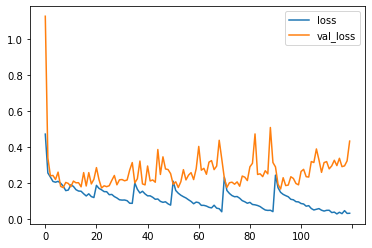

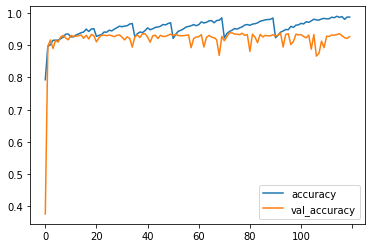

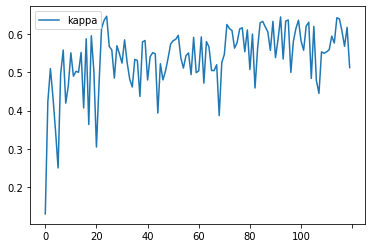

In [ ]:
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()
results[['kappa']].plot()
results.to_csv('results_3_all.csv',index=False)

# Find best threshold

In [ ]:
model.load_weights('denseNet_3_all.h5')
y_val_pred = model.predict(x_val)

def compute_score_inv(threshold):
    y1 = y_val_pred > threshold
    y1 = y1.astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')
    
    return 1 - score

simplex = scipy.optimize.minimize(
    compute_score_inv, 0.5, method='nelder-mead'
)

best_threshold = simplex['x'][0]

y1 = y_val_pred > best_threshold
y1 = y1.astype(int).sum(axis=1) - 1
y2 = y_val.sum(axis=1) - 1
score = cohen_kappa_score(y1, y2, weights='quadratic')
print('Threshold: {}'.format(best_threshold))
print('Validation QWK score with best_threshold: {}'.format(score))

y1 = y_val_pred > .5
y1 = y1.astype(int).sum(axis=1) - 1
score = cohen_kappa_score(y1, y2, weights='quadratic')
print('Validation QWK score with .5 threshold: {}'.format(score))

Threshold: 0.5359375000000001
Validation QWK score with best_threshold: 0.6493796450556493
Validation QWK score with .5 threshold: 0.6472545432308368


In [ ]:
%mv denseNet_3_all.h5 results_3_all.csv ../

In [ ]:
y_best = y_val_pred > best_threshold
y_best  = y_best .astype(int).sum(axis=1) - 1
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_best, y2))
print('Classification Report')
target_names = ['No DR', 'Moderate','Severe']
print(classification_report(y_best, y2, target_names=target_names))

Confusion Matrix
[[3084  499   17]
 [ 228  371   54]
 [   6   95  146]]
Classification Report
              precision    recall  f1-score   support

       No DR       0.93      0.86      0.89      3600
    Moderate       0.38      0.57      0.46       653
      Severe       0.67      0.59      0.63       247

    accuracy                           0.80      4500
   macro avg       0.66      0.67      0.66      4500
weighted avg       0.84      0.80      0.81      4500



In [ ]:
# score = model.evaluate(x_val, Y, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# Inference Kernel

https://www.kaggle.com/raimonds1993/aptos19-densenet-trained-with-old-and-new-data
